# Estimando parâmetros cosmológicos a partir de dados observacionais

$\textbf{RESUMO:}$ Este programa é um exemplo de uma análise estatística que tem como objetivo estimar o valor e os erros de diferentes parâmetros cosmológicos. Aqui detalho um versão em python (o original foi escrito em fortran) do código usado para obter os resuldados publicados em um artigo na Rev. Bras. Ensino Fís. 40 (2) 2018: $\href{https://doi.org/10.1590/1806-9126-RBEF-2017-0247}{\textit{Estimando parâmetros cosmológicos a partir de dados observacionais}}$. Portanto, para uma compreensão mais completa do código, inserimos algumas partes importante do referido artigo. 

In [1]:
#IMPORTANDO AS BIBLIOTECAS:
import numpy as np
import pandas as pd
import scipy.integrate as si # p/ intregrações
from scipy.optimize import minimize # p/ minimizar a função chi2
import matplotlib.pyplot as plt #p/ os plots
from joblib import Parallel, delayed # p/ executar um for em paralelo
from tqdm import tqdm # p/ executar um for em paralelo
import time # p/ determinar o tempo de duração de um processo
import scipy.interpolate # p/ interpolação de função rbf(xi, yi) a partir dos grid de dados 

## Dados

### Dados Observacionais de H(z)
O Parâmetro de Hubble, expressa a taxa com que o Universo se expande em um dado $z$. Este parâmetro carrega em si muitas características do modelo cosmológico. Na literatura é muito comum encontrá-lo expresso como sendo $H(z)= H_0E(\textbf{p};z)$. No caso específico do modelo $\Lambda$CDM plano toma a seguinte forma:
$$
\begin{eqnarray}
H(z)= H_0\sqrt{\Omega_{0,m}(1+z)^3+(1-\Omega_{0,m})}.
\label{H(z)Modelo}
\end{eqnarray} 
$$
	
A determinação de $H(z)$ em diferentes pontos da evolução do Universo pode nos ajudar a melhor entender a dinâmica de sua expansão, além disso, tem se mostrado bastante útil na realização de testes cosmológicos, como o desenvolvido neste trabalho. Na Tabela, são apresentada as 18 medidas de $H(z)$ usadas nas nossas análises.

In [2]:
# import numpy as np
# import pandas as pd
# definindo a função H(z), que tem como variáveis Om, h (=H0/100) e z
def Hzth(om, h, z):
    H0 = 100.*h
    Ez = np.sqrt(om*(1+z)**3.0 + (1.0 - om))
    Hz = H0*Ez
    return Hz

# Dados observacionais: [z, H(z), sigma] (ver Tabela 3 do artigo)
DataHz =[[0.090 , 69 , 12],    [0.170  ,83 ,  8],    [0.179  ,75 ,  4 ],    [0.199  ,75 ,  5],    [0.270  ,77 , 14],
         [0.352  ,83 , 14 ],    [0.400  ,95 , 17],    [0.480  ,97 , 62],    [0.593 ,104 , 13],    [0.680 , 92 ,  8], 
         [0.781 ,105 , 12 ],    [0.875 ,125 , 17],    [0.880 , 90 , 40],    [1.037 ,154 , 20 ],    [1.300 ,168 , 17 ], 
         [1.430 ,177  ,18 ],    [1.530 ,140 , 14 ],    [1.750 ,202,  40 ]]

print("Dados observacionais de H(z). A unidade das grandezas H(z) e sigma_{H(z)} estão em km s^{-1} Mpc^{-1}.")
display(pd.DataFrame(DataHz,columns=['z','H(z)','sigma_Hz']))

Dados observacionais de H(z). A unidade das grandezas H(z) e sigma_{H(z)} estão em km s^{-1} Mpc^{-1}.


,z,H(z),sigma_Hz
0,0.090,69,12
1,0.170,83,8
2,0.179,75,4
3,0.199,75,5
4,0.270,77,14
5,0.352,83,14
6,0.400,95,17
7,0.480,97,62
8,0.593,104,13
9,0.680,92,8


### Oscilações Acústicas dos Bárions
O levantamento realizado pelo SDSS \cite{Eisenstein2005} obteve um pico das BAO em $z_* \approx 0,35$. Para um Universo sem curvatura espacial, esse pico pode ser descrito por um parâmetro adimensional $A$, definido por D. J. Eisenstein $\textit{et al.}$ como sendo,
$$	
\begin{eqnarray}
A(\textbf{p};z_*)  \equiv  \frac{\sqrt{\Omega_{0,m}}}{E(\textbf{p};z_*)^{1/3}}\left(\frac{1}{z_*}\int_{0}^{z_*}\frac{dz}{E(\textbf{p};z)} \right)^{\frac{2}{3}} \label{A1}. 
\end{eqnarray}
$$
Para $z_* \approx 0,35$ eles obtiveram $A(\textbf{p};0,35)=  0,469 \pm 0,017$.
	
Atualmente existem medidas do pico das BAO em diferentes desvios para o vermelho. Para simplificar o cálculo numérico realizado neste trabalho, utilizou-se apenas uma das medidas do parâmetro $A(z_*)$, a medida obtida pelo levantamento SDSS em $z_*=0,35$.

In [3]:
# definindo a função que será integrada, que tem como variáveis Om, h e zz
def integrando_Xth(zz, om, h):
    H0=100.*h
    return H0/Hzth(om, h, zz) # 1/E(p;z)


# definindo a função A(p;z*), que tem como variáveis Om e h
# import scipy.integrate as si
def Ath(om, h):
    H0=100.*h
    z_asterisco = 0.35
    resut_Integral, erro_Xth = si.quad(integrando_Xth, 0, z_asterisco, args=(om, h))  # realizando a integração
    return (np.sqrt(om)/(Hzth(om, h, z_asterisco)/H0)**(1./3.))*((1./z_asterisco)*resut_Integral)**(2./3.)

## Método Qui-quadrado
	
Suponha que uma grandeza $F$, em um determinado modelo, é verdadeiramente expressa por uma função $F^{teó.}=F(\{\alpha_m\},z)$, onde $\{\alpha_m\}$ são os parâmetros deste modelo. Suponha também uma coleção de $N$ dados observacionais/experimentais $\{ z_{i},F^{obs}_{i},\sigma_{i} \}$, onde $F^{obs.}_{i}$ corresponde a medida da grandeza $F^{teó.}$ quando a grandeza $z$ é igual a $z_i$ e $\sigma_i$ corresponde a incerteza associada a medida de $F^{obs.}_{i}$. Assim sendo, a estatística de qui-quadrado ($\chi^2$) é expressa da seguinte forma: 
$	
\begin{eqnarray}
\chi^2=\sum_{i=1}^{N}\left( \frac{F(\{\alpha_m\},z)-F^{obs.}_{i}}{\sigma_{i}} \right)^2.
\label{chi2}
\end{eqnarray}	
$

O Método Qui-quadrado consiste em minimizar a estatística de qui-quadrado, variando os parâmetros do modelo. Esta técnica baseia-se na premissa de que o modelo é qualitativamente correto, e é ajustado para minimizar (via $\chi^2$) as diferenças entre o $F^{teó.}$ e o $F^{obs.}$. Tais diferenças são consideradas como sendo devido somente as flutuações estatísticas. Na prática, busca-se (por meios de computadores) os valores dos parâmetros que minimizam a estatística de qui-quadrado, pois esses são os que maximizam a função densidade de probabilidade ($L$) de obter a coleção de dados usados, uma vez que esta é:
$$
\begin{eqnarray}
L(\chi^2)\propto e^{-\frac{1}{2}\chi^2}.
\label{L}
\end{eqnarray}
$$
	
Uma das melhores características deste método é que ao mesmo tempo que se estima os parâmetros, verifica-se também a qualidade do ajuste, ou seja, determina se a função ajustada do modelo é verossímil (Porém, é necessário que as incertezas tenham sido estimadas corretamente). Isto é feito certificando se o valor do qui-quadrado mínimo ($\chi^{2}_{\text{mín.}}$) é próximo do número de graus de liberdade ($\nu$), que é dado por $\nu = N- m$, onde $m$ é o número de parâmetros livres e $N$ o de dados observacionais. Isto porque o valor mais provável do $\chi^2$, obtido pela condição de máximo da função de densidade de probabilidade, é aproximadamente igual ao $\nu$. Portanto, quanto mais próximo for o valor do $\chi^{2}_{\text{mín.}}$ do valor de $\nu$, melhor é o ajuste do modelo aos dados observacionais \cite{chi2}, ou ainda, quanto mais próximo for o qui-quadrado reduzido ($\chi^{2}_{\text{red}}$) de $1$, uma vez que:
$$	\begin{eqnarray}
	\chi^{2}_{\text{red}} \equiv \frac{\chi^{2}_{\text{mín.}}}{\nu}.
	\label{chi_red}
	\end{eqnarray}$$
	
Tendo encontrado os valores de melhor ajuste para os parâmetros, ou seja, aqueles que resultam no $\chi^{2}_{\text{mín.}}$ ou, equivalentemente, os que fornecem o ponto de máximo de $L$ ($L_{\text{max.}}=C e^{-\frac{1}{2}\chi^{2}_{\text{mín.}}}$), nos resta saber as regiões de confiança estatística para eles.  Tais regiões são definidas por       
$$	\begin{eqnarray}
	\chi^{2}_{\beta}= \chi^{2}_{\text{mín.}}+\Delta \chi^{2}(m,\beta),
	\label{regiao_de_confiança}
	\end{eqnarray}$$
	onde, $\Delta \chi^{2}$ representa o valor que delimita a região $\beta$ de confiança estatística. Na Tabela são mostrados os valores de $\Delta \chi^{2}$ que definem as três regiões de confiança estatística mais utilizadas. 
$$
\begin{aligned}
\text {Os valores de $\Delta \chi^{2}(m,\beta)$ que definem }\\
\text {as regiões de confiança estatística.}\\
\begin{array}{c|ccc}
\hline \hline
\beta 			 & m=1    &  m=2 & m=3\\ \hline
68,3\% (1 \sigma)& 1,00   & 2,30 &  3,53\\ 
95,4\% (2 \sigma)& 4,00 	& 6,17 &	8,02\\
99,7\% (3 \sigma)& 9,00   & 11,8 &	14,2\\ 
\hline \hline
\end{array}
\label{tabela_reg_confianca}
\end{aligned}
$$	
Em geral, os modelos cosmológicos possuem dois ou mais parâmetros. Para analisar cada um deles separadamente, faz-se uso de uma técnica chamada de marginalização, que consiste na integração (ou soma) da função densidade de probabilidade sobre todos os valores possível do parâmetro indesejado. Por exemplo, suponha uma função densidade de probabilidade $L(\alpha_1 , \alpha_2)$ de dois parâmetros $\alpha_1$ e $\alpha_2$, a função densidade de probabilidade marginalizada do parâmetro $\alpha_1$, será dada por: 
	\begin{eqnarray}
	L(\alpha_1)=\int L(\alpha_1 , \alpha_2) d\alpha_2.
	\label{Lmarg}
	\end{eqnarray}
	
Por fim, note que substituindo a equação (\ref{regiao_de_confiança}) na (\ref{L}), têm-se  
	\begin{eqnarray}
	L(\Delta \chi^{2})=L_{\text{max.}}e^{-\frac{1}{2}\Delta \chi^{2}}.
	\label{Lmax}
	\end{eqnarray}
Isso implica que para um único parâmetro, a região de $1 \sigma$ de confiança estatística é dada pela largura total de $L$ na altura
	\begin{eqnarray}
	L=L_{\text{max.}}e^{-\frac{1}{2}}\cong 0,6065L_{\text{max.}}.
	\label{Lmax1s}
	\end{eqnarray}	
	já a região de $2 \sigma$ é dada pela largura total de $L$ na altura
	\begin{eqnarray}
	L=L_{\text{max.}}e^{-2}\cong 0,1353L_{\text{max.}},
	\label{Lmax2s}
	\end{eqnarray}	 
e assim por diante (ver Figura 8 do artigo).

## Resultados
	
Nesta seção, usando o Método Qui-quadrado no âmbito do Modelo $\Lambda$CDM Plano, são apresentadas as estimativas dos parâmetros $H_0$, $\Omega_{0,m}$ e alguns outros correlacionados.

### Análise estatística individual: H(z)

A análise estatística utilizando os DO$H(z)$, é realizada tendo como $\chi^2$, a expressão:
$$
\begin{eqnarray}
	\chi^{2}_{H(z)}=\sum_{i=1}^{N}\left( \frac{H(\textbf{p};z_i)^{\text{teórico}}-H^{\text{obs}}_{i}}{\sigma^{\text{obs}}_{i}} \right)^2, 
	\label{chi_Hz}
	\end{eqnarray} 
 $$
onde o $H(\textbf{p};z_i)^{\text{teórico}}$ é o Parâmetro Hubble teórico, dado pela equação (\ref{H(z)Modelo}), $H^{\text{obs}}_{i}$ representa o valor observacional de $H(z)$ e $\sigma^{\text{obs}}_{i}$, a incerteza associada a medida de $H^{\text{obs}}_{i}$.

In [4]:
# definindo o Chi2 de Hz
    # lembre-se que:
    # DataHz[n][0] é o z, isto é, o elemento n da primeira coluna
    # DataHz[n][1] é a magnitude de Hz, isto é, o elemento n da segunda coluna
    # DataHz[n][2] é o erro de Hz, isto é, o elemento n da terceira coluna
    # len(DataHz) é o tamanho da amostra de dados
def chi2Hz(para):
    om, h =para
    soma_chi2_Hz = sum(
        ((Hzth(om, h, DataHz[n][0])-DataHz[n][1])/DataHz[n][2])**2.0 for n in range(len(DataHz)))
    return soma_chi2_Hz

# Minimizando Chi2 e obtendo os parâmetros que minimiza chi2
# from scipy.optimize import minimize # p/ minimizar a função chi2

para_ini = [0.3,0.7] # chute dos parâmetros iniciais do teste
initial = np.around(para_ini, len(para_ini)) 
soln = minimize(chi2Hz, initial, method='nelder-mead',
                options={'xatol': 1e-8, 'disp': True, 'maxiter': 1000}) # executando aminimização

param_min_Hz = np.around(soln['x'], 4)  
chi2_min_Hz = np.around(soln.fun, 2) 
# mostrando os resuldados:
print("Chi2min =",  np.around(soln.fun, 2),"Parâmetros que minimiza o Chi2[om,h] =>", param_min_Hz)

Optimization terminated successfully.
         Current function value: 12.424235
         Iterations: 52
         Function evaluations: 101
Chi2min = 12.42 Parâmetros que minimiza o Chi2[om,h] => [0.3171 0.6887]


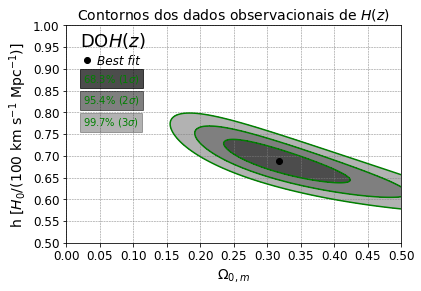

In [5]:
# comandos para a peparação do plot:
om_list = np.arange(0.0, 0.65,0.0025) # lista de valores de om
h_list = np.arange(0.45, 1.05, 0.0025) # lista de valores de h
X, Y = np.meshgrid(om_list, h_list) # grid de valores de om e h
Z_Hz = chi2Hz([X, Y]) # chi2 correspondente ao par de parâmetros om e h

# plote da figura:
plt.figure()
levels_Hz = [chi2_min_Hz,chi2_min_Hz+2.3,chi2_min_Hz+ 6.17,chi2_min_Hz+ 11.8] # 1, 2 e 3 sigmas
c = ((0,0,0,0.7), (0,0,0,0.5), (0,0,0,0.3)) # cores em rgb das regiões de 1, 2 e 3 sigmas
contour = plt.contour(X, Y, Z_Hz, levels_Hz, colors='green') # contornos de 1, 2 e 3 sigmasem em verde 
contour_filled = plt.contourf(X, Y, Z_Hz, levels_Hz, colors=c) # regiões de 1, 2 e 3 sigmas
plt.scatter(param_min_Hz[0], param_min_Hz[1], c='black') # ponto de melhor ajuste 

# custumizando o gráfico:
plt.title('Contornos dos dados observacionais de $H(z)$', fontsize=14) # titulo
plt.xlabel('$\Omega_{0,m}$ ', fontsize=14) 
plt.ylabel('h [$H_0$/(100 km s$^{-1}$ Mpc$^{-1}$)] ', fontsize=14)
plt.axis([0.0, 0.5, 0.5, 1.0]) # range
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 0.51, 0.05)) # grid ticks
plt.yticks(np.arange(0.5, 1.01, 0.05)) # grid ticks
plt.xticks(rotation=0) #rotação dos tick
plt.yticks(rotation=0) #rotação dos tick
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

#legenda:
plt.text(0.045, 0.91, r'Best fit',fontsize=12, style='italic', color='black') # legenda do ponto de melhor ajuste
plt.scatter(0.03, 0.92, c='black') # legenda do ponto de melhor ajuste
plt.text(0.02, 0.95, r'DO$H(z)$',fontsize=18)
plt.text(0.025, 0.87, r'$68.3 \% \ (1\sigma) $', style='italic', color='green', bbox={'facecolor': (0,0,0), 'alpha': 0.7, 'pad': 3})
plt.text(0.025, 0.82, r'$95.4 \% \ (2\sigma) $', style='italic', color='green', bbox={'facecolor': (0,0,0), 'alpha': 0.5, 'pad': 3})
plt.text(0.025, 0.77, r'$99.7 \% \ (3\sigma) $', style='italic', color='green', bbox={'facecolor': (0,0,0), 'alpha': 0.3, 'pad': 3})

plt.show()

#plt.savefig('contourplot_own_colours.png', dpi=300) # salvar no formato png

### Análise estatística individual: BAO

A análise estatística utilizando o BAO é realizada a partir do seguinte $\chi^2$:
$$
\begin{eqnarray}
	\chi^{2}_{BAO}=\left( \frac{A(\textbf{p};z_*)-0,469}{0,017} \right)^2, 
	\label{chi_bao}
	\end{eqnarray}
    $$
onde $A(\textbf{p};z_*)$ é a expressão teórica, dada pela equação (\ref{A1}), $0,469$ é o valor observacional de $A$ para um $z=0,35$ e $0,017$ é a incerteza associada a medida do $A$.

In [6]:
# definindo o Chi2 de BAO
def chi2BAO(para):
    om, h = para
    soma_chi2_BAO = ((Ath(om,h)- 0.469)/0.017)**2.0
    return soma_chi2_BAO

# Minimizando Chi2 e obtendo os parâmetros que minimiza chi2
# from scipy.optimize import minimize # p/ minimizar a função chi2

para_ini = [0.3,0.7] # chute dos parâmetros iniciais do teste
initial = np.around(para_ini, len(para_ini)) 
soln = minimize(chi2BAO, initial, method='nelder-mead',
                options={'xatol': 1e-8, 'disp': True, 'maxiter': 1000}) # executando aminimização

param_min_BAO = np.around(soln['x'], 4)  
chi2_min_BAO = np.around(soln.fun, 2) 
# mostrando os resuldados:
print("Chi2min =",  np.around(soln.fun, 2),"Parâmetros que minimiza o Chi2[om,h] =>", param_min_BAO)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 95
         Function evaluations: 216
Chi2min = 0.0 Parâmetros que minimiza o Chi2[om,h] => [0.2734 0.6785]


$\textbf{Obs:}$ Para obter os contornos de confiança estatística produzido pelo dado do BAO, faremos um pouco diferente do teste com dados de H(z), pois por ser apenas um dado e o $\chi^2$ ser degenerado em $h$, esse teste pruduz funções muito peculiares. Assim sendo, faremos de uma forma que exige mais poder computacional.

In [8]:
# comando para saber quantos CPU tem sua Máquina:
    #from multiprocessing import cpu_count
    #ncpu = cpu_count()
    #print("{0} CPUs".format(ncpu))

# Biblioteca e comando para executar o FOR em paralelo:
# from joblib import Parallel, delayed
# from tqdm import tqdm 
# import time 

om_list = np.arange(0.0, 0.65,0.0025) # lista de valores de om
h_list = np.arange(0.45, 1.05, 0.0025) # lista de valores de h

####### EXECUTANDO UM FOR SIMPLES ##########
# t_ini = time.time() # tempo de início
# chi2resut =[]
# for om in tqdm(om_list):
#     for h in h_list:
#         chi2resut.append([om,h,chi2BAO([om,h])])     
# print(f"Demorou : {time.time() - t_ini}") # tempo d fim menos o do de início em segundos
###########################################

####### EXECUTANDO UM FOR EM PARALELO ######
t_ini = time.time() # tempo de início
def om_h_chi2(om,h):
    listchi2 = [om,h,chi2BAO([om,h])]
    return listchi2

# n_jobs = 4  números de processadores que gostaria de usar
chi2resut = Parallel(n_jobs=4)(delayed(om_h_chi2)(om,h) for om in tqdm(om_list) for h in h_list)
print(f"Demorou : {time.time() - t_ini}") # tempo do fim menos o do de início em segundos

100%|███████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 533.40it/s]


Demorou : 0.7847137451171875


In [9]:
# comandos para a peparação a interpolação e o plot:
df = pd.DataFrame(chi2resut,columns=['om','h','chi2'])

# os comandos a seguir é para caso a comando "minimize" não obter valores coerentes: 
#indxmin = df['chi2'].idxmin() #determinado a posição do menor valor do chi2
#display(df.loc[indxmin]) # mostrando os malores que minimiza o chi2 
#chimin2 = df.loc[indxmin,'chi2']

dfsel = df.loc[df["chi2"] < chi2_min_BAO+20] # descartando os parâmetros cujo chi2 >> chi2min

x = dfsel["om"] # lista com os valores de om
y = dfsel["h"] # lista com os valores de h
z = dfsel["chi2"] # lista com os valores de chi2

# configurando uma grade regular de pontos de interpolação
xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
X, Y = np.meshgrid(xi, yi) # grid de valores de om e h

# INTERPOLANDO UMA FUNÇÂO A PARTIR DOS DADOS
# import scipy.interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
Z_BAO = rbf(X, Y) # essa função interpolada é equivalente a nosso chi2BAO

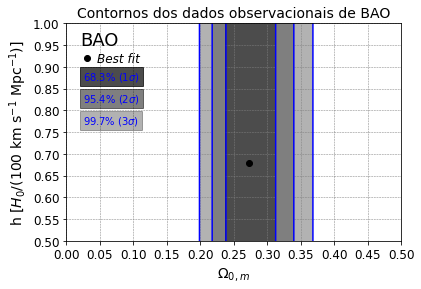

In [10]:
# plote da figura:
plt.figure()
levels_BAO = [chi2_min_BAO,chi2_min_BAO+2.3,chi2_min_BAO+ 6.17,chi2_min_BAO+ 11.8] # 1, 2 e 3 sigmas
c = ((0,0,0,0.7), (0,0,0,0.5), (0,0,0,0.3)) # cores em rgb das regiões de 1, 2 e 3 sigmas
contour = plt.contour(X, Y, Z_BAO, levels_BAO, colors='blue') # contornos de 1, 2 e 3 sigmasem em azul 
contour_filled = plt.contourf(X, Y, Z_BAO, levels_BAO, colors=c) # regiões de 1, 2 e 3 sigmas
plt.scatter(param_min_BAO[0], param_min_BAO[1], c='black') # ponto de melhor ajuste 

# custumizando o gráfico:
plt.title('Contornos dos dados observacionais de BAO', fontsize=14) # titulo
plt.xlabel('$\Omega_{0,m}$ ', fontsize=14) 
plt.ylabel('h [$H_0$/(100 km s$^{-1}$ Mpc$^{-1}$)] ', fontsize=14)
plt.axis([0.0, 0.5, 0.5, 1.0]) # range
plt.grid(True,color='grey', linestyle='--', linewidth=0.5) #grid 
plt.xticks(np.arange(0, 0.51, 0.05)) # grid ticks
plt.yticks(np.arange(0.5, 1.01, 0.05)) # grid ticks
plt.xticks(rotation=0) #rotação dos tick
plt.yticks(rotation=0) #rotação dos tick
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

#legenda:
plt.text(0.045, 0.91, r'Best fit',fontsize=12, style='italic', color='black') # legenda do ponto de melhor ajuste
plt.scatter(0.03, 0.92, c='black') # legenda do ponto de melhor ajuste
plt.text(0.02, 0.95, r'BAO',fontsize=18)
plt.text(0.025, 0.87, r'$68.3 \% \ (1\sigma) $', style='italic', color='blue', bbox={'facecolor': (0,0,0), 'alpha': 0.7, 'pad': 3})
plt.text(0.025, 0.82, r'$95.4 \% \ (2\sigma) $', style='italic', color='blue', bbox={'facecolor': (0,0,0), 'alpha': 0.5, 'pad': 3})
plt.text(0.025, 0.77, r'$99.7 \% \ (3\sigma) $', style='italic', color='blue', bbox={'facecolor': (0,0,0), 'alpha': 0.3, 'pad': 3})

plt.show()

#plt.savefig('contourplot_own_colours.png', dpi=300) # salvar no formato png

### Análise estatística conjunta: DOH(z) + BAO

A análise estatística conjunta é realizada a partir do seguinte $\chi^2$:
$$
\begin{eqnarray}
	\chi^{2}_{H(z) + BAO}&=&\sum_{i=1}^{N}\left( \frac{H(\textbf{p};z_i)^{\text{teórico}}-H^{\text{obs}}_{i}}{\sigma^{\text{obs}}_{i}} \right)^2 \nonumber \\
						& &+\left( \frac{A(\textbf{p};z_*)-0,469}{0,017} \right)^2. 
	\label{chi_Hz+BAO}
	\end{eqnarray}
$$

In [11]:
# definindo o Chi2 completo H(z)+BAO
def chi2Comp(para):
    om, h =para
    return chi2Hz([om,h])+rbf(om,h) # lembre que rbf(om,h) equivale a nossa função chi2BAO

# Minimizando Chi2 e obtendo os parâmetros que minimiza chi2
# from scipy.optimize import minimize # p/ minimizar a função chi2

para_ini = [0.3,0.7] # chute dos parâmetros iniciais do teste
initial = np.around(para_ini, len(para_ini)) 
soln = minimize(chi2Comp, initial, method='nelder-mead',
                options={'xatol': 1e-8, 'disp': True, 'maxiter': 1000}) # executando aminimização

param_min_Comp = np.around(soln['x'], 4)  
chi2_min_Comp = np.around(soln.fun, 2) 
# mostrando os resuldados:
print("Chi2min =",  np.around(soln.fun, 2),"Parâmetros que minimiza o Chi2[om,h] =>", param_min_Comp)

Optimization terminated successfully.
         Current function value: 12.900161
         Iterations: 55
         Function evaluations: 103
Chi2min = 12.9 Parâmetros que minimiza o Chi2[om,h] => [0.2804 0.7058]


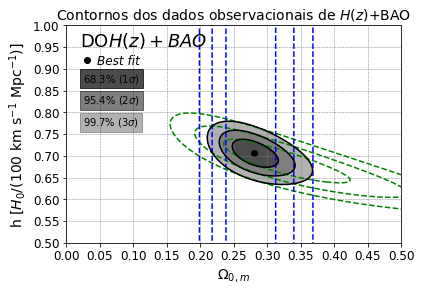

In [12]:
# comandos para a peparação do plot:
om_list = np.arange(0.0, 0.65,0.0025) # lista de valores de om
h_list = np.arange(0.45, 1.05, 0.0025) # lista de valores de h
X, Y = np.meshgrid(om_list, h_list) # grid de valores de om e h
Z_Comp = chi2Comp([X, Y]) # chi2 correspondente ao par de parâmetros om e h

# plote da figura:
plt.figure()

#### contornos anteriores de Hz e BAO ########
contour = plt.contour(X, Y, Z_Hz, levels_Hz, colors='green', linestyles='dashed')
contour = plt.contour(xi, yi, Z_BAO, levels_BAO, colors='blue', linestyles='dashed')
##############################################

levels_Comp = [chi2_min_Comp,chi2_min_Comp+2.3,chi2_min_Comp+ 6.17,chi2_min_Comp+ 11.8] # 1, 2 e 3 sigmas
c = ((0,0,0,0.7), (0,0,0,0.5), (0,0,0,0.3)) # cores em rgb das regiões de 1, 2 e 3 sigmas
contour = plt.contour(X, Y, Z_Comp, levels_Comp, colors='black') # contornos de 1, 2 e 3 sigmasem em verde
contour_filled = plt.contourf(X, Y, Z_Comp, levels_Comp, colors=c) # regiões de 1, 2 e 3 sigmas
plt.scatter(param_min_Comp[0], param_min_Comp[1], c='black') # ponto de melhor ajuste 

# custumizando o gráfico:
plt.title('Contornos dos dados observacionais de $H(z)$+BAO', fontsize=14) # titulo
plt.xlabel('$\Omega_{0,m}$ ', fontsize=14) 
plt.ylabel('h [$H_0$/(100 km s$^{-1}$ Mpc$^{-1}$)] ', fontsize=14)
plt.axis([0.0, 0.5, 0.5, 1.0]) # range
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 0.51, 0.05)) # grid ticks
plt.yticks(np.arange(0.5, 1.01, 0.05)) # grid ticks
plt.xticks(rotation=0) #rotação dos tick
plt.yticks(rotation=0) #rotação dos tick
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

#legenda:
plt.text(0.045, 0.91, r'Best fit',fontsize=12, style='italic', color='black') # legenda do ponto de melhor ajuste
plt.scatter(0.03, 0.92, c='black') # legenda do ponto de melhor ajuste
plt.text(0.02, 0.95, r'DO$H(z)+BAO$',fontsize=18)
plt.text(0.025, 0.87, r'$68.3 \% \ (1\sigma) $', style='italic', color='black', bbox={'facecolor': (0,0,0), 'alpha': 0.7, 'pad': 3})
plt.text(0.025, 0.82, r'$95.4 \% \ (2\sigma) $', style='italic', color='black', bbox={'facecolor': (0,0,0), 'alpha': 0.5, 'pad': 3})
plt.text(0.025, 0.77, r'$99.7 \% \ (3\sigma) $', style='italic', color='black', bbox={'facecolor': (0,0,0), 'alpha': 0.3, 'pad': 3})

plt.show()

#plt.savefig('contourplot_own_colours.png', dpi=300) # salvar no formato png

### Funcão de densidade de probabilidade magnalizada
Como comentado na primeira seção, para analisar cada um dos parâmetros separadamente, faz-se uso de uma técnica chamada de marginalização, que consiste na integração (ou soma) da função densidade de probabilidade ($cte\ e^{-\frac{\chi^{2}}{2}}$) sobre todos os valores possível do parâmetro indesejado.

In [22]:
om_list = np.arange(0.0, 0.52,0.001)
h_list = np.arange(0.48, 1.02, 0.001)

####### MARGINALIZANDO COM UM FOR SIMPLES ######

# t_ini = time.time() # tempo de início

# # magnalizando sobre om:
# list_probh=[]
# for h in h_list:
#     list_probh.append([h,sum(np.exp(-chi2Comp([om,h])/2) for om in om_list)])

# # magnalizando sobre h:
# list_probom=[]
# for om in om_list:
#     list_probom.append([om,sum(np.exp(-chi2Comp([om,h])/2) for h in h_list)])
    
# print(f"Demorou : {time.time() - t_ini}") # tempo do fim menos o do de início em segundos


####### MARGINALIZANDO COM UM FOR EM PARALELO ######

t_ini = time.time() # tempo de início

# magnalizando sobre o parametro h:
def h_Lh(h):
    soma_om = sum(np.exp(-chi2Comp([om,h])/2) for om in om_list)
    return [h,soma_om]

# n_jobs = 4  números de processadores que gostaria de usar
list_probh = Parallel(n_jobs=4)(delayed(h_Lh)(h) for h in tqdm(h_list))

def om_Lom(om):
    soma_h = sum(np.exp(-chi2Comp([om,h])/2) for h in h_list)
    return [om,soma_h]

 # n_jobs = 4  números de processadores que gostaria de usar
list_probom = Parallel(n_jobs=4)(delayed(om_Lom)(om) for om in tqdm(om_list))

print(f"Demorou : {time.time() - t_ini}") # tempo do fim menos o do de início em segundos

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [00:12<00:00, 40.18it/s]


Demorou : 26.58518958091736


h        0.705000
probh    0.077103
Name: 225, dtype: float64

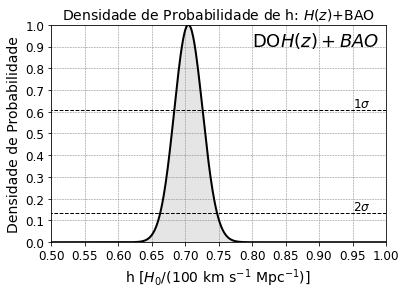

In [23]:
### PLOT DA FUNÇÃO DENSIDADE DE PROBABILIDADE DE H:

list_probh_df = pd.DataFrame(list_probh,columns=['h','probh']) # lista com valoes de h e sua função densid. de probab.

indxmaxh = list_probh_df['probh'].idxmax() # localizando indx dos valores de máxima probabilidade 
display(list_probh_df.loc[indxmaxh]) # mostrando valores de máxima probabilidade
probh_max = list_probh_df.loc[indxmaxh,'probh'] # valor da probab. máxima (usado para plotar: prob(h)/prob_max)
h_probmax = list_probh_df.loc[indxmaxh,'h'] # valor de h que máxima a prob.

plt.plot(list_probh_df['h'], list_probh_df['probh']/probh_max,color='black', linestyle='-', linewidth=2.0)

# custumizando o gráfico:
plt.title('Densidade de Probabilidade de h: $H(z)$+BAO', fontsize=14) # titulo
plt.xlabel('h [$H_0$/(100 km s$^{-1}$ Mpc$^{-1}$)] ', fontsize=14) 
plt.ylabel('Densidade de Probabilidade', fontsize=14)
plt.axis([0.5, 1.0, 0.0, 1.0]) # range
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0.5, 1.05, 0.05)) # grid ticks
plt.yticks(np.arange(0.0, 1.1, 0.1)) # grid ticks
plt.xticks(rotation=0) #rotação dos tick
plt.yticks(rotation=0) #rotação dos tick
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.text(0.8, 0.9, r'DO$H(z)+BAO$',fontsize=18)

# Sombreia a área entre y= probh e a linha y=0.
plt.fill_between(list_probh_df['h'], list_probh_df['probh']/probh_max, 0,
                # facecolor="red", # The fill color
                 color='grey',       # The outline color
                 alpha=0.2)          # Transparency of the fill

# Incluindo retas tracejadas que delimitam a região de 1 e 2 sigmas 
#(veja última parte da seção : Qui-quadrado)
plt.plot([0.48,1.05], [0.6065,0.6065],color='black', linestyle='--', linewidth=1.0)
plt.text(0.95, 0.62, r'$1\sigma$',fontsize=12)
plt.plot([0.48,1.05], [0.1353,0.1353],color='black', linestyle='--', linewidth=1.0)
plt.text(0.95, 0.15, r'$2\sigma$',fontsize=12)

plt.show()
#plt.savefig('contourplot_own_colours.png', dpi=300) # salvar no formato png

In [24]:
### Obtendo os limites de confiança estatistica de 1 e 2 sigma:
h1s = list_probh_df.loc[(list_probh_df['probh']/probh_max) >= 0.6065]
h1smin=h1s['h'].min()
h1smax=h1s['h'].max()
h2s = list_probh_df.loc[(list_probh_df['probh']/probh_max) >= 0.1353]
h2smin=h2s['h'].min()
h2smax=h2s['h'].max()

print(r'h =',np.around(h_probmax,3),"+/-",np.around((h1smax-h1smin)/2,3), r"1\sigma c.l.")
print(r'h =',np.around(h_probmax,3),"+/-",np.around((h2smax-h2smin)/2,3), r"2\sigma c.l.")

h = 0.705 +/- 0.021 1\sigma c.l.
h = 0.705 +/- 0.042 2\sigma c.l.


om        0.28000
probom    0.07185
Name: 280, dtype: float64

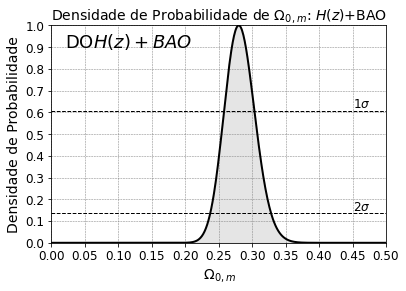

In [25]:
### PLOT DA FUNÇÃO DENSIDADE DE PROBABILIDADE DE OM:

list_probom_df = pd.DataFrame(list_probom,columns=['om','probom']) # lista com valoes de om e sua função densid. de probab.

indxmaxom = list_probom_df['probom'].idxmax() # localizando indx dos valores de máxima probabilidade 
display(list_probom_df.loc[indxmaxom]) # mostrando valores de máxima probabilidade
probom_max = list_probom_df.loc[indxmaxom,'probom'] # valor da probab. máxima (usado para plotar: prob(om)/prob_max)
om_probmax = list_probom_df.loc[indxmaxom,'om'] # valor de om que máxima a prob.

plt.plot(list_probom_df['om'], list_probom_df['probom']/probom_max,color='black', linestyle='-', linewidth=2.0)

# custumizando o gráfico:
plt.title('Densidade de Probabilidade de $\Omega_{0,m}$: $H(z)$+BAO', fontsize=14) # titulo
plt.xlabel(' $\Omega_{0,m}$ ', fontsize=14) 
plt.ylabel('Densidade de Probabilidade', fontsize=14)
plt.axis([0.0, 0.5, 0.0, 1.0]) # range
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0.0, 0.55, 0.05)) # grid ticks
plt.yticks(np.arange(0.0, 1.1, 0.1)) # grid ticks
plt.xticks(rotation=0) #rotação dos tick
plt.yticks(rotation=0) #rotação dos tick
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.text(0.02, 0.9, r'DO$H(z)+BAO$',fontsize=18)

# Sombreia a área entre y= probh e a linha y=0.
plt.fill_between(list_probom_df['om'], list_probom_df['probom']/probom_max, 0,
                # facecolor="red", # The fill color
                 color='grey',       # The outline color
                 alpha=0.2)          # Transparency of the fill

# Incluindo retas tracejadas que delimitam a região de 1 e 2 sigmas 
#(veja última parte da seção : Qui-quadrado)
plt.plot([0.,0.55], [0.6065,0.6065],color='black', linestyle='--', linewidth=1.0)
plt.text(0.45, 0.62, r'$1\sigma$',fontsize=12)
plt.plot([0.,0.55], [0.1353,0.1353],color='black', linestyle='--', linewidth=1.0)
plt.text(0.45, 0.15, r'$2\sigma$',fontsize=12)

plt.show()
#plt.savefig('contourplot_own_colours.png', dpi=300) # salvar no formato png

In [26]:
### Obtendo os limites de confiança estatistica de 1 e 2 sigma:
om1s = list_probom_df.loc[(list_probom_df['probom']/probom_max) >= 0.6065]
om1smin=om1s['om'].min()
om1smax=om1s['om'].max()
om2s = list_probom_df.loc[(list_probom_df['probom']/probom_max) >= 0.1353]
om2smin=om2s['om'].min()
om2smax=om2s['om'].max()

print(r'Omega_m =',om_probmax,"+/-",np.around((om1smax-om1smin)/2,3), r"1\sigma c.l.")
print(r'Omega_m =',om_probmax,"+/-",np.around((om2smax-om2smin)/2,3), r"2\sigma c.l.")


Omega_m = 0.28 +/- 0.022 1\sigma c.l.
Omega_m = 0.28 +/- 0.045 2\sigma c.l.
